# Explore here

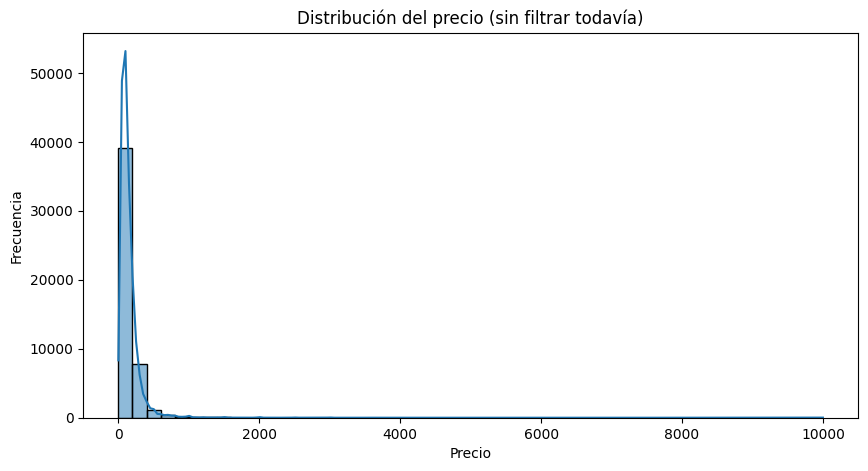

In [51]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest, f_regression 
import matplotlib.pyplot as plt
import seaborn as sns

# Creamos una carpeta para los datos si no existe
carpeta_datos = "./datos"
os.makedirs(carpeta_datos, exist_ok=True)

# Bajamos los datos de internet y los guardamos
enlace = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
ruta_datos = os.path.join(carpeta_datos, "AB_NYC_2019.csv")
df = pd.read_csv(enlace)
df.to_csv(ruta_datos, index=False)

# Primer vistazo: histograma del precio
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribución del precio (sin filtrar todavía)")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

In [52]:
# Limpiamos los datos chungos
df['ultima_resena'] = df['last_review'].fillna('Sin reseñas')  # Rellenamos reseñas vacías
df['resenas_por_mes'] = df['reviews_per_month'].fillna(0)     # Si no hay reseñas por mes, ponemos 0
df = df.drop_duplicates()                                     # Quitamos filas repetidas

# Filtramos precios raros con el método de los cuartiles
q1, q3 = df['price'].quantile([0.25, 0.75])
iqr = q3 - q1
limite_inferior, limite_superior = q1 - 1.5 * iqr, q3 + 1.5 * iqr
df = df[(df['price'] >= limite_inferior) & (df['price'] <= limite_superior) & (df['price'] > 0)]

# Filtramos noches mínimas raras también
q1, q3 = df['minimum_nights'].quantile([0.25, 0.75])
iqr = q3 - q1
limite_inferior, limite_superior = q1 - 1.5 * iqr, q3 + 1.5 * iqr
df = df[(df['minimum_nights'] >= limite_inferior) & (df['minimum_nights'] <= limite_superior) & (df['minimum_nights'] > 0)]

In [53]:
# Quitamos columnas que no nos sirven pa nada
df.drop(["id", "name", "host_id", "host_name", "last_review", "reviews_per_month", "latitude", "longitude", "neighbourhood"], axis=1, inplace=True)

# Creamos una columna nueva: precio por noche
df['precio_por_noche'] = df['price'] / df['minimum_nights']

# Clasificamos los precios en categorías (bajo, medio, alto)
def clasificar_precio(precio):
    if precio < 50:
        return "Bajo"
    elif precio < 150:
        return "Medio"
    else:
        return "Alto"

df['categoria_precio'] = df['price'].apply(clasificar_precio)

# Convertimos columnas categóricas a números
df["tipo_habitacion"] = pd.factorize(df["room_type"])[0]
df["grupo_vecindario"] = pd.factorize(df["neighbourhood_group"])[0]
df.drop("room_type", axis=1, inplace=True)
df.drop("neighbourhood_group", axis=1, inplace=True)

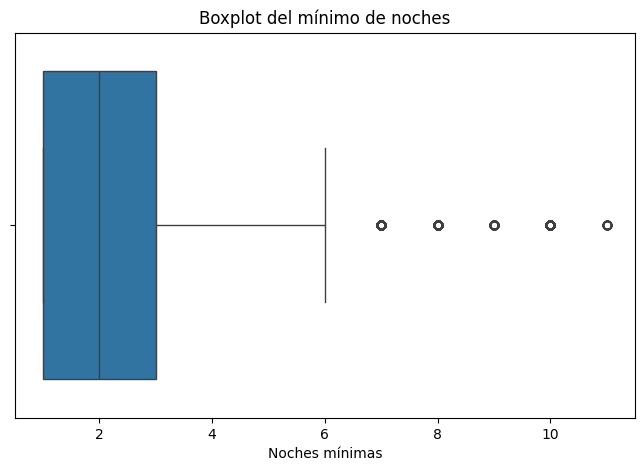

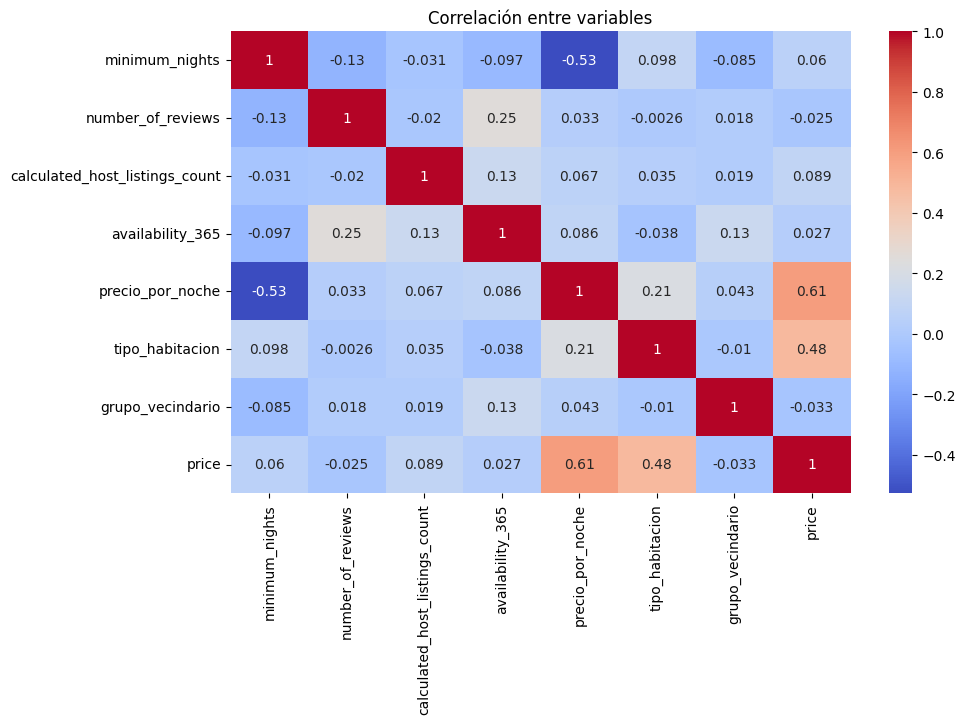

In [54]:
# Boxplot de las noches mínimas 
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['minimum_nights'])
plt.title("Boxplot del mínimo de noches")
plt.xlabel("Noches mínimas")
plt.show()

columnas_numericas = ["minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365", "precio_por_noche", "tipo_habitacion", "grupo_vecindario"]

# Mapa de calor de correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(df[columnas_numericas + ["price"]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables")
plt.show()

# Escalamos los datos pa que no haya líos con los rangos
escalador = MinMaxScaler()
df_escalado = pd.DataFrame(escalador.fit_transform(df[columnas_numericas + ["price"]]), columns=columnas_numericas + ["price"])

# Separamos en X (variables) e y (precio)
X = df_escalado.drop("price", axis=1)
y = df_escalado["price"]

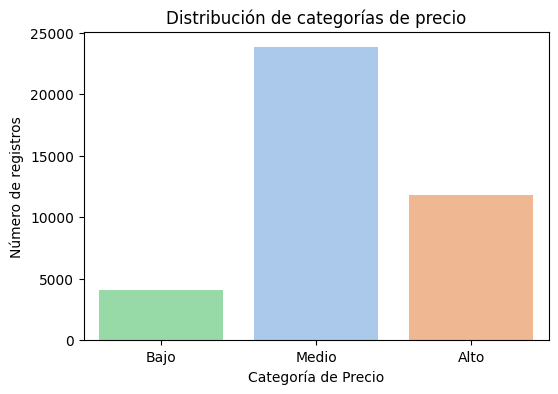

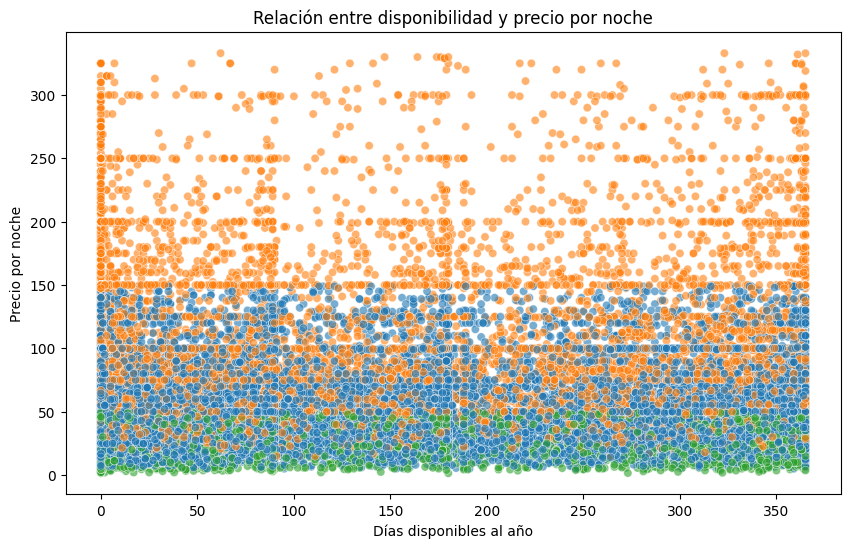

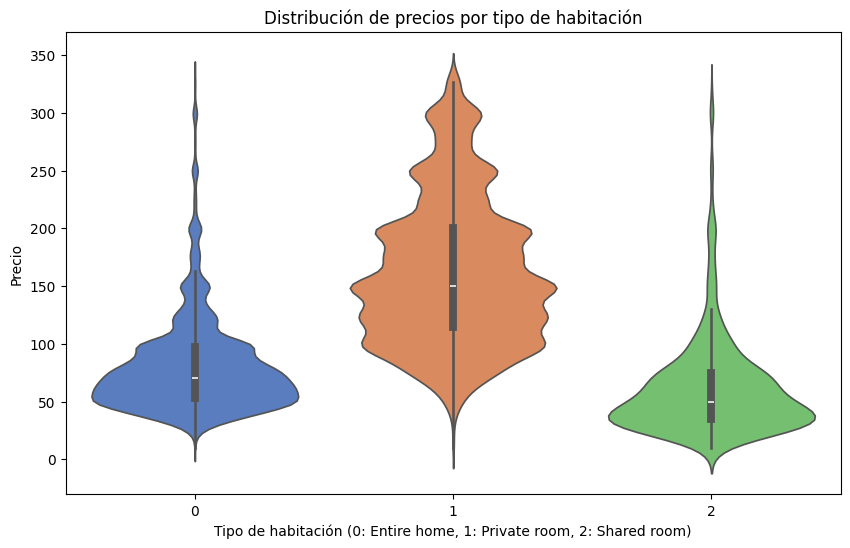

In [ ]:
#Hay mucha correlación entre precio por noche por lo que podemos observar arriba
#Tipo de habitación tiene correlación por lo que tienen más precio las habitaciónes privadas que es lo normal
#Las dos de arribas son las más fuertes precio por noche y tipo de habitación las otra son bastante bajas.
#Además podemos ver que la mayoria coge 2 noches


# Gráfico de barras de las categorías de precio
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="categoria_precio", hue="categoria_precio", order=["Bajo", "Medio", "Alto"], palette="pastel", legend=False)
plt.title("Distribución de categorías de precio")
plt.xlabel("Categoría de Precio")
plt.ylabel("Número de registros")
plt.show()

# Gráfico de dispersión pa ver disponibilidad vs precio por noche
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="availability_365", y="precio_por_noche", hue="categoria_precio", alpha=0.6, legend=False)
plt.title("Relación entre disponibilidad y precio por noche")
plt.xlabel("Días disponibles al año")
plt.ylabel("Precio por noche")
plt.show()

# Nuevo gráfico: violin plot p’ ver cómo se distribuyen los precios por tipo de habitación
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="tipo_habitacion", y="price", hue="tipo_habitacion", palette="muted", legend=False)
plt.title("Distribución de precios por tipo de habitación")
plt.xlabel("Tipo de habitación (0: Entire home, 1: Private room, 2: Shared room)")
plt.ylabel("Precio")
plt.show()

In [ ]:
# Dividimos en entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

# Seleccionamos las 4 mejores variables con f_regression
modelo_seleccion = SelectKBest(f_regression, k=4) 
modelo_seleccion.fit(X_entrenamiento, y_entrenamiento)
indices = modelo_seleccion.get_support()
X_entrenamiento_sel = pd.DataFrame(modelo_seleccion.transform(X_entrenamiento), columns=X_entrenamiento.columns.values[indices])
X_prueba_sel = pd.DataFrame(modelo_seleccion.transform(X_prueba), columns=X_prueba.columns.values[indices])

# Añadimos el precio a los datos seleccionados
X_entrenamiento_sel["price"] = list(y_entrenamiento)
X_prueba_sel["price"] = list(y_prueba)

# Guardamos los datos procesados en una carpeta nueva
carpeta_procesados = "./datos_procesados"
os.makedirs(carpeta_procesados, exist_ok=True)
X_entrenamiento_sel.to_csv(os.path.join(carpeta_procesados, "entrenamiento.csv"), index=False)
X_prueba_sel.to_csv(os.path.join(carpeta_procesados, "prueba.csv"), index=False)
